# Initialization
- import relevant libraries
- create device and img_size variables

In [ ]:
import torch
from torch import device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()

cuda:0


In [ ]:
import math
from torch import nn, einsum
import torch.nn.functional as F
from inspect import isfunction
from functools import partial
import numpy as np
from tqdm import tqdm
import os
from PIL import Image
import torchvision
from torchvision.transforms import ToTensor, Normalize, ToPILImage
from torchvision.transforms import functional as trans_fn
from sklearn.model_selection import train_test_split
import os
import shutil
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
img_size = 512
lr_width, lr_height = 128, 128 # 4x reduction
batch_size = 4

In [ ]:
# to keep track of train/test loss curves
create_loss_csv = 1
if (create_loss_csv == 1):
    with open('satellite/train_test_loss.csv', 'w', newline='') as csvfile:
        fieldnames = ['epoch', 'train_loss', 'test_loss']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

# Prepare Data
adapted code from Jiang Guan
(only need to run this when data is just downloaded)

In [ ]:
# download the image the google bucket
download_original = 0
if download_original == 1: 
    image_url = 'https://storage.googleapis.com/acv_project/landscape_img.zip'
    !curl -O $image_url
    !unzip landscape_img
    !rm landscape_img.zip
    # push all the images into a single place:
    os.mkdir('./satellite/data/original') 
    for place in os.listdir('./landscape_img'): 
        for img in os.listdir(os.path.join('./landscape_img', place)):
            shutil.copy(os.path.join(os.path.join('./landscape_img', place), img), './satellite/data/original')
    !rm -r landscape_img

In [ ]:
generate_data = 0
if generate_data == 1: 
    # train test split
    # split by id 
    img_id = os.listdir('./satellite/data/original')
    train_id, test_id = train_test_split(img_id, test_size=0.1, random_state=1)      

    # create test and train folder    
    !rm -rf ./train
    os.mkdir('./satellite/data/train') 
    os.mkdir('./satellite/data/train/original') # save all train data to this path

    !rm -rf ./test
    os.mkdir('./satellite/data/test') 
    os.mkdir('./satellite/data/test/original') # save all train data to this path

    # save img into the respective folders as 1x downsampling
    for id in train_id: 
        shutil.copy('./satellite/data/original/' + id, './satellite/data/train/original')

    for id in test_id: 
        shutil.copy('./satellite/data/original/' + id, './satellite/data/test/original')

    # downscale images via Pillow 
    # this will take quite some time to run
    downscale_factor_list = [1, 2, 4]
    for path in ['./satellite/data/train/', './satellite/data/test/']:
        img_id_list = os.listdir(path + 'original/')
        for img_id in tqdm(img_id_list): 
            img = Image.open(path + 'original/' + img_id)
            img = img.resize((img_size, img_size)) 

            img_arr_1x = np.array(img) # 1x downscale

            # downscale and upscale again (bicubic method)
            img_4x = img.resize((lr_width, lr_height)) 
            img_4x = img_4x.resize((img_size, img_size))
            img_arr_4x = np.array(img_4x) # 4x downscale
            np.save(os.path.join(path, img_id[:-4]), np.stack((img_arr_1x, img_arr_4x)))
    
    !rm -rf ./satellite/data/train/original
    !rm -rf ./satellite/data/test/original

# Dataset and Dataloader
adapted from Jiang Guan


In [ ]:
# dataset and dataloader
class SatelliteDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir
        self.img_files = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        # load the image from disk 
        img_arr = np.load(os.path.join(self.img_dir, self.img_files[idx]))
        img_1x = Image.fromarray(img_arr[0])
        img_4x = Image.fromarray(img_arr[1])

        # apply flip, rotate, and convert to tensor 
        # flipping
  
        c = np.random.randint(0,3)
        if c == 1: 
            img_1x = trans_fn.hflip(img_1x)
            img_4x = trans_fn.hflip(img_4x)
        elif c == 2: 
            img_1x = trans_fn.vflip(img_1x)
            img_4x = trans_fn.vflip(img_4x)
        elif c == 3: 
            img_1x = trans_fn.vflip(img_1x)
            img_4x = trans_fn.vflip(img_4x)
            img_1x = trans_fn.hflip(img_1x)
            img_4x = trans_fn.hflip(img_4x)

        # rotation
        c = np.random.randint(0,3)
        img_1x  = trans_fn.rotate(img_1x, 90*c)
        img_4x  = trans_fn.rotate(img_4x, 90*c)

        # to tensor 
        img_1x = ToTensor()(img_1x)
        img_4x = ToTensor()(img_4x)

        return {'1x': img_1x, '4x': img_4x}
        img_4x, img_1x

img_size = 256 # change image size back to 256x256 since 512x512 is too large

def collate_fn(batch):
    # Filter failed images first
    batch = list(filter(lambda x: x is not None, batch))
    img_1x_lst = []
    img_4x_lst = []
    
    for b in batch:
        img_1x_lst.append(b['1x'][:,0:img_size,0:img_size])
        img_1x_lst.append(b['1x'][:,0:img_size,img_size:2*img_size])
        img_1x_lst.append(b['1x'][:,img_size:2*img_size,0:img_size])
        img_1x_lst.append(b['1x'][:,img_size:2*img_size,img_size:2*img_size])

        img_4x_lst.append(b['4x'][:,0:img_size,0:img_size])
        img_4x_lst.append(b['4x'][:,0:img_size,img_size:2*img_size])
        img_4x_lst.append(b['4x'][:,img_size:2*img_size,0:img_size])
        img_4x_lst.append(b['4x'][:,img_size:2*img_size,img_size:2*img_size])

    # Now collate into mini-batches
    img_1x = torch.stack(img_1x_lst)
    img_4x = torch.stack(img_4x_lst)
    return {'HR': img_1x, 'SR': img_4x}

# implement custom image_dataset and wrap it with the dataloader
image_datasets = {x: SatelliteDataset(os.path.join('./satellite/data/', x)) for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, 
                                              shuffle=True, num_workers=0, collate_fn = collate_fn)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print('size of dataset', dataset_sizes)

size of dataset {'train': 9000, 'test': 1000}


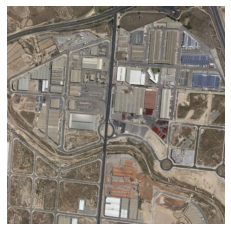

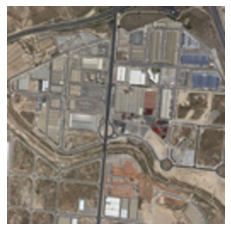

In [ ]:
image = image_datasets['test'][80]
plt.axis("off")
plt.imshow(image['1x'].permute(1, 2, 0))
plt.show()
plt.axis("off")
plt.imshow(image['4x'].permute(1, 2, 0))
plt.show()

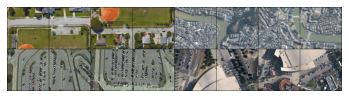

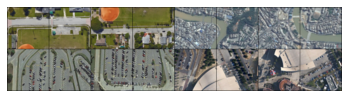

In [ ]:
# Get a batch of training data
import cv2
batch = next(iter(dataloaders['train']))
HR = torchvision.utils.make_grid(batch["HR"])
SR = torchvision.utils.make_grid(batch["SR"])
plt.axis("off")
plt.imshow(HR.permute(1, 2, 0))
plt.show()
plt.axis("off")
plt.imshow(SR.permute(1, 2, 0))
plt.show()

# Code for SR3 Model 
Modified https://github.com/Janspiry/Image-Super-Resolution-via-Iterative-Refinement/blob/master/model/sr3_modules/diffusion.py (unoffical code for SR3)


Hyperparameters changed for Unet (with reference to config files for sr3):
- changed inner_channel from 64 to 32
- changed channel_mults from [1, 2, 4, 8, 8] to [1, 2, 4, 8]
- changed attn_res from [16] to [8]
- changed res_blocks from 2 to 1
- kept dropout at 0.2
- set image_size at 256

Hyperparameters changed for GaussianDiffusion:
- set timesteps as 500 under set_new_noise_schedule()


Changes made: 
- remove use of base model and model_opt
- adjusted hyperparameters of the model so that it is smaller
- wrote training loop

In [ ]:
def _warmup_beta(linear_start, linear_end, n_timestep, warmup_frac):
    betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    warmup_time = int(n_timestep * warmup_frac)
    betas[:warmup_time] = np.linspace(
        linear_start, linear_end, warmup_time, dtype=np.float64)
    return betas


def make_beta_schedule(schedule, n_timestep, linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3):
    if schedule == 'quad':
        betas = np.linspace(linear_start ** 0.5, linear_end ** 0.5,
                            n_timestep, dtype=np.float64) ** 2
    elif schedule == 'linear':
        betas = np.linspace(linear_start, linear_end,
                            n_timestep, dtype=np.float64)
    elif schedule == 'warmup10':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.1)
    elif schedule == 'warmup50':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.5)
    elif schedule == 'const':
        betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    elif schedule == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1. / np.linspace(n_timestep,
                                 1, n_timestep, dtype=np.float64)
    elif schedule == "cosine":
        timesteps = (
            torch.arange(n_timestep + 1, dtype=torch.float64) /
            n_timestep + cosine_s
        )
        alphas = timesteps / (1 + cosine_s) * math.pi / 2
        alphas = torch.cos(alphas).pow(2)
        alphas = alphas / alphas[0]
        betas = 1 - alphas[1:] / alphas[:-1]
        betas = betas.clamp(max=0.999)
    else:
        raise NotImplementedError(schedule)
    return betas


def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


class GaussianDiffusion(nn.Module):
    def __init__(
        self,
        denoise_fn,
        image_size,
        channels=3,
        loss_type='l1',
        conditional=True
    ):
        super().__init__()
        self.channels = channels
        self.image_size = image_size
        self.denoise_fn = denoise_fn
        self.loss_type = loss_type
        self.conditional = conditional
        self.set_new_noise_schedule(device)

    def set_loss(self, device):
        if self.loss_type == 'l1':
            self.loss_func = nn.L1Loss(reduction='sum').to(device)
        elif self.loss_type == 'l2':
            self.loss_func = nn.MSELoss(reduction='sum').to(device)
        else:
            raise NotImplementedError()

    def set_new_noise_schedule(self, device, schedule="linear", n_timestep=500, linear_start=1e-6, linear_end=0.01):
        to_torch = partial(torch.tensor, dtype=torch.float32, device=device)

        betas = make_beta_schedule(
            schedule=schedule,
            n_timestep=n_timestep,
            linear_start=linear_start,
            linear_end=linear_end)
        betas = betas.detach().cpu().numpy() if isinstance(
            betas, torch.Tensor) else betas
        alphas = 1. - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1., alphas_cumprod[:-1])
        self.sqrt_alphas_cumprod_prev = np.sqrt(
            np.append(1., alphas_cumprod))

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)
        self.register_buffer('betas', to_torch(betas))
        self.register_buffer('alphas_cumprod', to_torch(alphas_cumprod))
        self.register_buffer('alphas_cumprod_prev',
                             to_torch(alphas_cumprod_prev))

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('sqrt_alphas_cumprod',
                             to_torch(np.sqrt(alphas_cumprod)))
        self.register_buffer('sqrt_one_minus_alphas_cumprod',
                             to_torch(np.sqrt(1. - alphas_cumprod)))
        self.register_buffer('log_one_minus_alphas_cumprod',
                             to_torch(np.log(1. - alphas_cumprod)))
        self.register_buffer('sqrt_recip_alphas_cumprod',
                             to_torch(np.sqrt(1. / alphas_cumprod)))
        self.register_buffer('sqrt_recipm1_alphas_cumprod',
                             to_torch(np.sqrt(1. / alphas_cumprod - 1)))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = betas * \
            (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)
        self.register_buffer('posterior_variance',
                             to_torch(posterior_variance))
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.register_buffer('posterior_log_variance_clipped', to_torch(
            np.log(np.maximum(posterior_variance, 1e-20))))
        self.register_buffer('posterior_mean_coef1', to_torch(
            betas * np.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)))
        self.register_buffer('posterior_mean_coef2', to_torch(
            (1. - alphas_cumprod_prev) * np.sqrt(alphas) / (1. - alphas_cumprod)))

    def predict_start_from_noise(self, x_t, t, noise):
        return self.sqrt_recip_alphas_cumprod[t] * x_t - \
            self.sqrt_recipm1_alphas_cumprod[t] * noise

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = self.posterior_mean_coef1[t] * \
            x_start + self.posterior_mean_coef2[t] * x_t
        posterior_log_variance_clipped = self.posterior_log_variance_clipped[t]
        return posterior_mean, posterior_log_variance_clipped

    def p_mean_variance(self, x, t, clip_denoised: bool, condition_x=None):
        batch_size = x.shape[0]
        noise_level = torch.FloatTensor(
            [self.sqrt_alphas_cumprod_prev[t+1]]).repeat(batch_size, 1).to(x.device)
        if condition_x is not None:
            x_recon = self.predict_start_from_noise(
                x, t=t, noise=self.denoise_fn(torch.cat([condition_x, x], dim=1), noise_level))
        else:
            x_recon = self.predict_start_from_noise(
                x, t=t, noise=self.denoise_fn(x, noise_level))

        if clip_denoised:
            x_recon.clamp_(-1., 1.)

        model_mean, posterior_log_variance = self.q_posterior(
            x_start=x_recon, x_t=x, t=t)
        return model_mean, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, x, t, clip_denoised=True, condition_x=None):
        model_mean, model_log_variance = self.p_mean_variance(
            x=x, t=t, clip_denoised=clip_denoised, condition_x=condition_x)
        noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
        return model_mean + noise * (0.5 * model_log_variance).exp()

    @torch.no_grad()
    def p_sample_loop(self, x_in, continous=False):
        device = self.betas.device
        sample_inter = (1 | (self.num_timesteps//10))
        if not self.conditional:
            shape = x_in
            img = torch.randn(shape, device=device)
            ret_img = img
            for i in tqdm(reversed(range(0, self.num_timesteps)), desc='sampling loop time step', total=self.num_timesteps):
                img = self.p_sample(img, i)
                if i % sample_inter == 0:
                    ret_img = torch.cat([ret_img, img], dim=0)
        else:
            x = x_in
            shape = x.shape
            img = torch.randn(shape, device=device)
            ret_img = x
            for i in tqdm(reversed(range(0, self.num_timesteps)), desc='sampling loop time step', total=self.num_timesteps):
                img = self.p_sample(img, i, condition_x=x)
                if i % sample_inter == 0:
                    ret_img = torch.cat([ret_img, img], dim=0)
        if continous:
            return ret_img
        else:
            return ret_img[-1]

    @torch.no_grad()
    def sample(self, batch_size=1, continous=False):
        image_size = self.image_size
        channels = self.channels
        return self.p_sample_loop((batch_size, channels, image_size, image_size), continous)

    @torch.no_grad()
    def super_resolution(self, x_in, continous=False):
        return self.p_sample_loop(x_in, continous)

    def q_sample(self, x_start, continuous_sqrt_alpha_cumprod, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        # random gama
        return (
            continuous_sqrt_alpha_cumprod * x_start +
            (1 - continuous_sqrt_alpha_cumprod**2).sqrt() * noise
        )

    def p_losses(self, x_in, noise=None):
        x_start = x_in['HR']
        [b, c, h, w] = x_start.shape
        t = np.random.randint(1, self.num_timesteps + 1)
        continuous_sqrt_alpha_cumprod = torch.FloatTensor(
            np.random.uniform(
                self.sqrt_alphas_cumprod_prev[t-1],
                self.sqrt_alphas_cumprod_prev[t],
                size=b
            )
        ).to(x_start.device)
        continuous_sqrt_alpha_cumprod = continuous_sqrt_alpha_cumprod.view(
            b, -1)

        noise = default(noise, lambda: torch.randn_like(x_start))
        x_noisy = self.q_sample(
            x_start=x_start, continuous_sqrt_alpha_cumprod=continuous_sqrt_alpha_cumprod.view(-1, 1, 1, 1), noise=noise)

        if not self.conditional:
            x_recon = self.denoise_fn(x_noisy, continuous_sqrt_alpha_cumprod)
        else:
            x_recon = self.denoise_fn(
                torch.cat([x_in['SR'], x_noisy], dim=1), continuous_sqrt_alpha_cumprod)

        loss = self.loss_func(noise, x_recon)
        return loss

    def forward(self, x, *args, **kwargs):
        return self.p_losses(x, *args, **kwargs)

In [ ]:
import math
import torch
from torch import nn
import torch.nn.functional as F
from inspect import isfunction


def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class PositionalEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, noise_level):
        count = self.dim // 2
        step = torch.arange(count, dtype=noise_level.dtype,
                            device=noise_level.device) / count
        encoding = noise_level.unsqueeze(
            1) * torch.exp(-math.log(1e4) * step.unsqueeze(0))
        encoding = torch.cat(
            [torch.sin(encoding), torch.cos(encoding)], dim=-1)
        return encoding


class FeatureWiseAffine(nn.Module):
    def __init__(self, in_channels, out_channels, use_affine_level=False):
        super(FeatureWiseAffine, self).__init__()
        self.use_affine_level = use_affine_level
        self.noise_func = nn.Sequential(
            nn.Linear(in_channels, out_channels*(1+self.use_affine_level))
        )

    def forward(self, x, noise_embed):
        batch = x.shape[0]
        if self.use_affine_level:
            gamma, beta = self.noise_func(noise_embed).view(
                batch, -1, 1, 1).chunk(2, dim=1)
            x = (1 + gamma) * x + beta
        else:
            x = x + self.noise_func(noise_embed).view(batch, -1, 1, 1)
        return x


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class Upsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv = nn.Conv2d(dim, dim, 3, padding=1)

    def forward(self, x):
        return self.conv(self.up(x))


class Downsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv2d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)


# building block modules


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=32, dropout=0):
        super().__init__()
        self.block = nn.Sequential(
            nn.GroupNorm(groups, dim),
            Swish(),
            nn.Dropout(dropout) if dropout != 0 else nn.Identity(),
            nn.Conv2d(dim, dim_out, 3, padding=1)
        )

    def forward(self, x):
        return self.block(x)


class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, noise_level_emb_dim=None, dropout=0, use_affine_level=False, norm_groups=32):
        super().__init__()
        self.noise_func = FeatureWiseAffine(
            noise_level_emb_dim, dim_out, use_affine_level)

        self.block1 = Block(dim, dim_out, groups=norm_groups)
        self.block2 = Block(dim_out, dim_out, groups=norm_groups, dropout=dropout)
        self.res_conv = nn.Conv2d(
            dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb):
        b, c, h, w = x.shape
        h = self.block1(x)
        h = self.noise_func(h, time_emb)
        h = self.block2(h)
        return h + self.res_conv(x)


class SelfAttention(nn.Module):
    def __init__(self, in_channel, n_head=1, norm_groups=32):
        super().__init__()

        self.n_head = n_head

        self.norm = nn.GroupNorm(norm_groups, in_channel)
        self.qkv = nn.Conv2d(in_channel, in_channel * 3, 1, bias=False)
        self.out = nn.Conv2d(in_channel, in_channel, 1)

    def forward(self, input):
        batch, channel, height, width = input.shape
        n_head = self.n_head
        head_dim = channel // n_head

        norm = self.norm(input)
        qkv = self.qkv(norm).view(batch, n_head, head_dim * 3, height, width)
        query, key, value = qkv.chunk(3, dim=2)  # bhdyx

        attn = torch.einsum(
            "bnchw, bncyx -> bnhwyx", query, key
        ).contiguous() / math.sqrt(channel)
        attn = attn.view(batch, n_head, height, width, -1)
        attn = torch.softmax(attn, -1)
        attn = attn.view(batch, n_head, height, width, height, width)

        out = torch.einsum("bnhwyx, bncyx -> bnchw", attn, value).contiguous()
        out = self.out(out.view(batch, channel, height, width))

        return out + input


class ResnetBlocWithAttn(nn.Module):
    def __init__(self, dim, dim_out, *, noise_level_emb_dim=None, norm_groups=32, dropout=0, with_attn=False):
        super().__init__()
        self.with_attn = with_attn
        self.res_block = ResnetBlock(
            dim, dim_out, noise_level_emb_dim, norm_groups=norm_groups, dropout=dropout)
        if with_attn:
            self.attn = SelfAttention(dim_out, norm_groups=norm_groups)

    def forward(self, x, time_emb):
        x = self.res_block(x, time_emb)
        if(self.with_attn):
            x = self.attn(x)
        return x


class UNet(nn.Module):
    def __init__(
        self,
        in_channel=6,
        out_channel=3,
        inner_channel=32,
        norm_groups=8,
        channel_mults=[1, 2, 4, 8],
        attn_res=[8],
        res_blocks=1,
        dropout=0.2,
        with_noise_level_emb=True,
        image_size=img_size
    ):
        super().__init__()

        if with_noise_level_emb:
            noise_level_channel = inner_channel
            self.noise_level_mlp = nn.Sequential(
                PositionalEncoding(inner_channel),
                nn.Linear(inner_channel, inner_channel * 4),
                Swish(),
                nn.Linear(inner_channel * 4, inner_channel)
            )
        else:
            noise_level_channel = None
            self.noise_level_mlp = None

        num_mults = len(channel_mults)
        pre_channel = inner_channel
        feat_channels = [pre_channel]
        now_res = image_size
        downs = [nn.Conv2d(in_channel, inner_channel,
                           kernel_size=3, padding=1)]
        for ind in range(num_mults):
            is_last = (ind == num_mults - 1)
            use_attn = (now_res in attn_res)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks):
                downs.append(ResnetBlocWithAttn(
                    pre_channel, channel_mult, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups, dropout=dropout, with_attn=use_attn))
                feat_channels.append(channel_mult)
                pre_channel = channel_mult
            if not is_last:
                downs.append(Downsample(pre_channel))
                feat_channels.append(pre_channel)
                now_res = now_res//2
        self.downs = nn.ModuleList(downs)

        self.mid = nn.ModuleList([
            ResnetBlocWithAttn(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                               dropout=dropout, with_attn=True),
            ResnetBlocWithAttn(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                               dropout=dropout, with_attn=False)
        ])

        ups = []
        for ind in reversed(range(num_mults)):
            is_last = (ind < 1)
            use_attn = (now_res in attn_res)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks+1):
                ups.append(ResnetBlocWithAttn(
                    pre_channel+feat_channels.pop(), channel_mult, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                        dropout=dropout, with_attn=use_attn))
                pre_channel = channel_mult
            if not is_last:
                ups.append(Upsample(pre_channel))
                now_res = now_res*2

        self.ups = nn.ModuleList(ups)

        self.final_conv = Block(pre_channel, default(out_channel, in_channel), groups=norm_groups)

    def forward(self, x, time):
        t = self.noise_level_mlp(time) if exists(
            self.noise_level_mlp) else None

        feats = []
        for layer in self.downs:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(x, t)
            else:
                x = layer(x)
            feats.append(x)

        for layer in self.mid:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(x, t)
            else:
                x = layer(x)

        for layer in self.ups:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(torch.cat((x, feats.pop()), dim=1), t)
            else:
                x = layer(x)

        return self.final_conv(x)

In [ ]:
model = UNet().to(device)

In [ ]:
def get_model_info(model):
    # Compute number of trainable parameters in the model
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # Compute the size of the model in MB
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
        
    size_all_mb = (param_size + buffer_size) / 1024**2
    
    return num_params, size_all_mb

In [ ]:
netG = GaussianDiffusion(model,img_size,device).to(device)
netG.set_loss(device)

In [ ]:
# Print model info
num_params, size_all_mb = get_model_info(netG)

print("Number of trainable params:", num_params)
print('Model size: {:.3f}MB'.format(size_all_mb))

Number of trainable params: 9736547
Model size: 37.165MB


In [ ]:
optG = torch.optim.Adam(netG.parameters(), lr=2e-4)

# Image for visualization

1x image


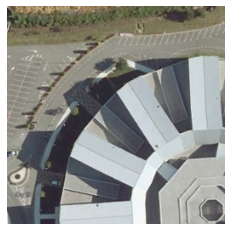

4x image


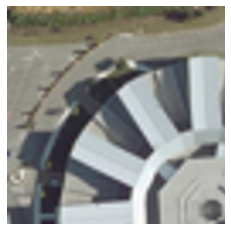

resulting image


sampling loop time step:   0%|          | 0/500 [00:02<?, ?it/s]


KeyboardInterrupt: ignored

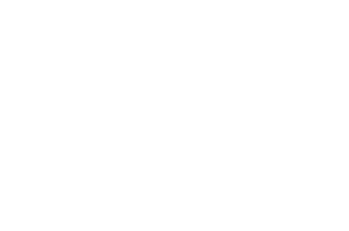

In [ ]:
# visualize image
visualize_image = image_datasets['test'][8]

print("1x image")
plt.axis("off")
plt.imshow(visualize_image['1x'][:,0:img_size,0:img_size].permute(1, 2, 0))
plt.show()

print("4x image")
plt.axis("off")
plt.imshow(visualize_image['4x'][:,0:img_size,0:img_size].permute(1, 2, 0))
plt.show()

print("resulting image")
plt.axis("off")
plt.imshow(netG.super_resolution(visualize_image['4x'][:,0:img_size,0:img_size][None,:].to(device)).permute(1, 2, 0).cpu())
plt.show()

# Training loop

Wrote training loop and added visualization in training process

In [ ]:
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])     

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [ ]:
def train_model(netG, optG, start_epoch=0, end_epoch=10):

    for epoch in range(start_epoch, end_epoch):
        print(f'Epoch {epoch}/{end_epoch - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        loss_dict = {'epoch': epoch, 'train_loss': -100, 'test_loss': -100}
        for phase in ['train', 'test']:

            if phase == 'train':
                netG.train()  # Set model to training mode
            else:
                netG.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for batch in tqdm(dataloaders[phase]):

                HR_img = batch["HR"].to(device)
                SR_img = batch["SR"].to(device)

                # zero the parameter gradients
                optG.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    l_pix = netG({"HR": HR_img, "SR": SR_img})

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        l_pix.backward()
                        optG.step()

                    # statistics
                    running_loss += l_pix.item()

            epoch_loss = running_loss / (dataset_sizes[phase] * 4)

            if phase == 'train':
                loss_dict['train_loss'] = epoch_loss
            else:
                loss_dict['test_loss'] = epoch_loss

            print(f'{phase} Loss: {epoch_loss:.4f}')
        
        with open('satellite/train_test_loss.csv', 'a', newline='') as csvfile:
            fieldnames = ['epoch', 'train_loss', 'test_loss']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerows([loss_dict])

        # include visualization at start to see progress
        plt.axis("off")
        plt.imshow(netG.super_resolution(visualize_image['4x'][:,0:img_size,0:img_size][None,:].to(torch.float16).to(device)).permute(1, 2, 0).cpu())
        plt.show()

        print()

        checkpoint = {
            "state_dict": netG.state_dict(),
            "optimizer": optG.state_dict(),
        }
        
        save_checkpoint(checkpoint, f'./satellite/model_weights/epoch{epoch}.pth.tar')
        print()

=> Loading checkpoint
Epoch 17/31
----------


100%|██████████| 2250/2250 [38:39<00:00,  1.03s/it]


train Loss: 47488.3937


100%|██████████| 250/250 [01:27<00:00,  2.86it/s]


test Loss: 42255.0630


sampling loop time step: 100%|██████████| 500/500 [00:11<00:00, 42.18it/s]


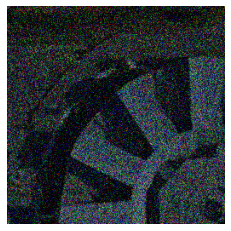


=> Saving checkpoint

Epoch 18/31
----------


100%|██████████| 2250/2250 [38:36<00:00,  1.03s/it]


train Loss: 46732.5774


100%|██████████| 250/250 [01:26<00:00,  2.88it/s]


test Loss: 51154.5626


sampling loop time step: 100%|██████████| 500/500 [00:11<00:00, 42.56it/s]


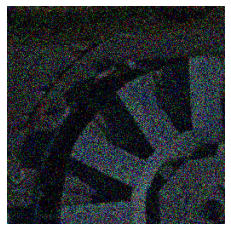


=> Saving checkpoint

Epoch 19/31
----------


100%|██████████| 2250/2250 [38:35<00:00,  1.03s/it]


train Loss: 48221.9111


100%|██████████| 250/250 [01:26<00:00,  2.88it/s]


test Loss: 52503.1294


sampling loop time step: 100%|██████████| 500/500 [00:11<00:00, 42.47it/s]


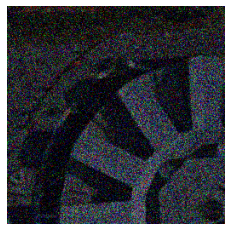


=> Saving checkpoint

Epoch 20/31
----------


100%|██████████| 2250/2250 [38:39<00:00,  1.03s/it]


train Loss: 46079.4409


100%|██████████| 250/250 [01:26<00:00,  2.88it/s]


test Loss: 51917.5835


sampling loop time step: 100%|██████████| 500/500 [00:11<00:00, 42.61it/s]


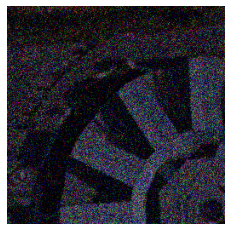


=> Saving checkpoint

Epoch 21/31
----------


100%|██████████| 2250/2250 [38:33<00:00,  1.03s/it]


train Loss: 45779.1274


100%|██████████| 250/250 [01:26<00:00,  2.88it/s]


test Loss: 46379.4378


sampling loop time step: 100%|██████████| 500/500 [00:11<00:00, 42.63it/s]


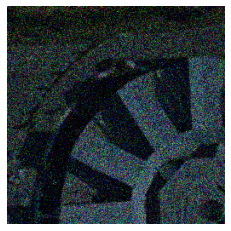


=> Saving checkpoint

Epoch 22/31
----------


100%|██████████| 2250/2250 [38:35<00:00,  1.03s/it]


train Loss: 48295.6288


100%|██████████| 250/250 [01:26<00:00,  2.88it/s]


test Loss: 41538.1045


sampling loop time step: 100%|██████████| 500/500 [00:11<00:00, 42.52it/s]


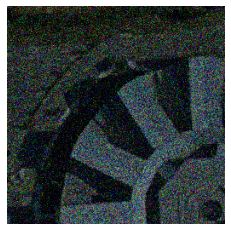


=> Saving checkpoint

Epoch 23/31
----------


 58%|█████▊    | 1311/2250 [22:29<16:06,  1.03s/it]


KeyboardInterrupt: ignored

In [ ]:
start_epoch = 23
if start_epoch > 0:
    load_checkpoint(torch.load(f'./satellite/model_weights/epoch{start_epoch-1}.pth.tar'), netG, optG)
train_model(netG, optG, start_epoch=start_epoch, end_epoch=start_epoch+15)

# Load saved model

In [ ]:
import cv2
def image_convert(image):
    image = image.clone().permute(1, 2, 0).cpu().numpy()
    image = cv2.normalize(image, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
    return image

1x image


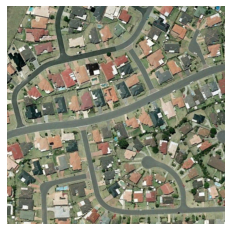

4x image


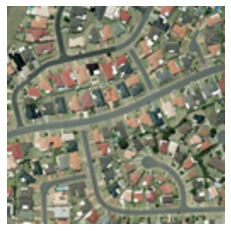

=> Loading checkpoint


sampling loop time step: 100%|██████████| 500/500 [00:49<00:00, 10.09it/s]


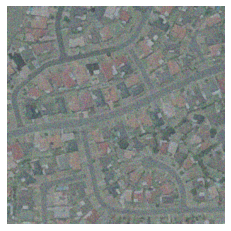

In [ ]:
visualize_image = image_datasets['test'][113]

print("1x image")
plt.axis("off")
plt.imshow(visualize_image['1x'].permute(1, 2, 0))
plt.show()

print("4x image")
plt.axis("off")
plt.imshow(visualize_image['4x'].permute(1, 2, 0))
plt.show()

load_checkpoint(torch.load("./satellite/model_weights/epoch22.pth.tar"), netG, optG)

plt.axis("off")
plt.imshow(image_convert(netG.super_resolution(visualize_image['4x'][None,:].to(device))))
plt.show()

In [ ]:
print(np.load('./satellite/data/train/square_218.npy')[1].shape)

(512, 512, 3)


=> Loading checkpoint


sampling loop time step: 100%|██████████| 500/500 [00:49<00:00, 10.10it/s]


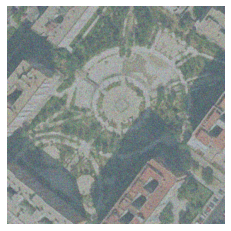

In [ ]:
load_checkpoint(torch.load("./satellite/model_weights/epoch22.pth.tar"), netG, optG)
plt.axis("off")
input_img = np.load('./satellite/data/train/square_218.npy')
input_img = Image.fromarray(input_img[1])
input_img = ToTensor()(input_img)[None,:].to(device)
output_img = netG.super_resolution(input_img)
plt.imshow(image_convert(output_img))
plt.show()

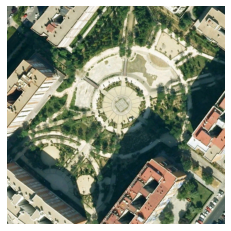

In [ ]:
plt.axis("off")
plt.imshow(np.load('./satellite/data/train/square_218.npy')[0])
plt.show()

sampling loop time step: 100%|██████████| 500/500 [00:49<00:00, 10.05it/s]


NameError: ignored

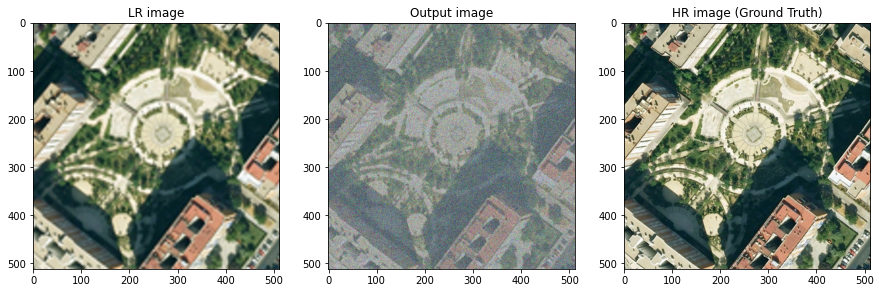

In [ ]:
input = np.load('./satellite/data/train/square_218.npy')[1]
target = np.load('./satellite/data/train/square_218.npy')[0]
input_img = Image.fromarray(input)
input_img = ToTensor()(input_img)[None,:].to(device)
output = netG.super_resolution(input_img)

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
axs[0].imshow(input)
axs[0].set_title('LR image')
axs[1].imshow(image_convert(output))
axs[1].set_title('Output image')
axs[2].imshow(target)
axs[2].set_title('HR image (Ground Truth)')
plt.savefig("satellite/results/test_image{}.pdf".format(i), format = "pdf", bbox_inches = "tight")
plt.show()

sampling loop time step: 100%|██████████| 500/500 [00:49<00:00, 10.11it/s]


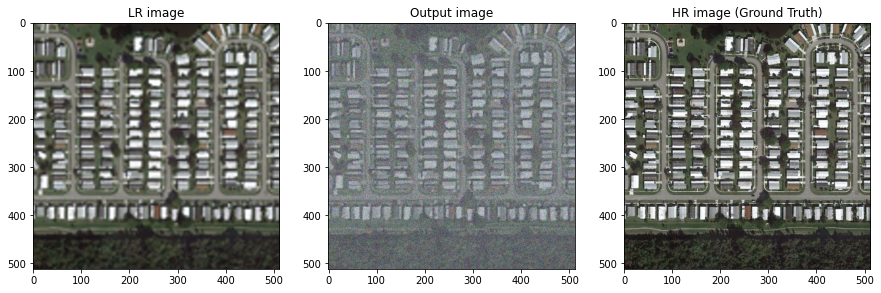

In [ ]:
input = np.load('./satellite/data/train/denseresidential_364.npy')[1]
target = np.load('./satellite/data/train/denseresidential_364.npy')[0]
input_img = Image.fromarray(input)
input_img = ToTensor()(input_img)[None,:].to(device)
output = netG.super_resolution(input_img)

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
axs[0].imshow(input)
axs[0].set_title('LR image')
axs[1].imshow(image_convert(output))
axs[1].set_title('Output image')
axs[2].imshow(target)
axs[2].set_title('HR image (Ground Truth)')
plt.savefig("satellite/results/train_image_denseresidential_364.pdf", format = "pdf", bbox_inches = "tight")
plt.show()

# Performance evaluation on testing dataset
modified from Xinwen's code

In [ ]:
!pip install torchmetrics
!pip install lpips
from torchmetrics import PeakSignalNoiseRatio
from torchmetrics import StructuralSimilarityIndexMeasure
import lpips
psnr = PeakSignalNoiseRatio().to(device)
ssim = StructuralSimilarityIndexMeasure().to(device)
loss_fn = lpips.LPIPS(net='alex').to(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.8/dist-packages/lpips/weights/v0.1/alex.pth


In [ ]:
def image_convert(image):
    image = image.clone().permute(1, 2, 0).cpu().numpy()
    image = cv2.normalize(image, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
    return image

In [ ]:
# Evaluate model performance on test dataset
def test_eval(test_data, model):
    l1_loss = []
    mse_loss = []
    psnr_list = []
    ssim_list = []
    output_list = []
    lpips_list = []
    criterion1 = nn.L1Loss()
    criterion2 = nn.MSELoss()

    model.eval()
    with torch.no_grad():
        for i in range(0,100,10):
            images = test_data[i]
            input = images['4x']
            target = images['1x']
            input = input.to(device)
            target = target.to(device)
            output = netG.super_resolution(input[None,:])
            output_list.append(output.clone().cpu().detach().numpy())

            # Compute L1 loss
            loss = criterion1(output,target)
            l1_loss.append(loss.item())

            # Compute MSE loss
            loss2 = criterion2(output,target)
            mse_loss.append(loss2.item())

            # Compute PSNR 
            psnr_value = psnr(output.to(device), target)
            psnr_value = psnr_value.clone().cpu().detach().numpy()
            psnr_list.append(psnr_value)
            
            # Compute SSIM
            ssim_value = ssim(output.unsqueeze(0), target.unsqueeze(0))
            ssim_value = ssim_value.clone().cpu().detach().numpy()
            ssim_list.append(ssim_value)

            # Compute LPIPS
            d = loss_fn.forward(output,target).clone().cpu().detach().numpy()
            lpips_list.append(d)

            # Display the LR image, output image and HR image.
            plt.figure(i)
            fig, axs = plt.subplots(1, 3, figsize=(15, 10))
            axs[0].imshow(image_convert(input))
            axs[0].set_title('LR image')
            axs[1].imshow(image_convert(output))
            axs[1].set_title('Output image')
            axs[2].imshow(image_convert(target))
            axs[2].set_title('HR image (Ground Truth)')
            plt.savefig("satellite/results/test_image{}.pdf".format(i), format = "pdf", bbox_inches = "tight")
            plt.show()
    return l1_loss, mse_loss, psnr_list, ssim_list, lpips_list, output_list

=> Loading checkpoint


sampling loop time step: 100%|██████████| 500/500 [00:48<00:00, 10.32it/s]


<Figure size 432x288 with 0 Axes>

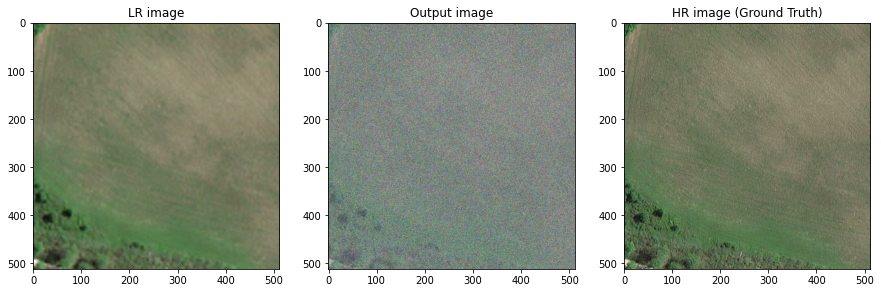

sampling loop time step: 100%|██████████| 500/500 [00:47<00:00, 10.43it/s]


<Figure size 432x288 with 0 Axes>

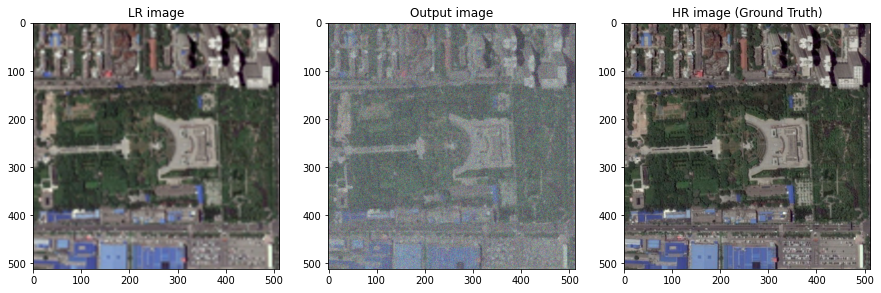

sampling loop time step: 100%|██████████| 500/500 [00:48<00:00, 10.37it/s]


<Figure size 432x288 with 0 Axes>

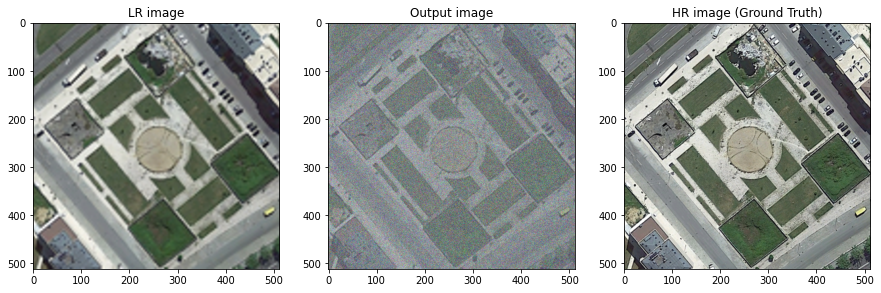

sampling loop time step: 100%|██████████| 500/500 [00:48<00:00, 10.41it/s]


<Figure size 432x288 with 0 Axes>

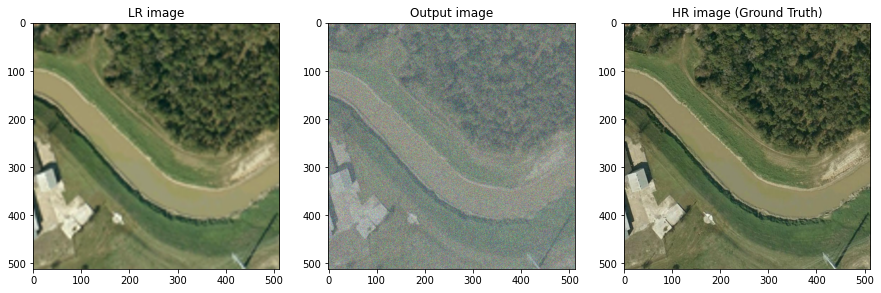

sampling loop time step: 100%|██████████| 500/500 [00:48<00:00, 10.39it/s]


<Figure size 432x288 with 0 Axes>

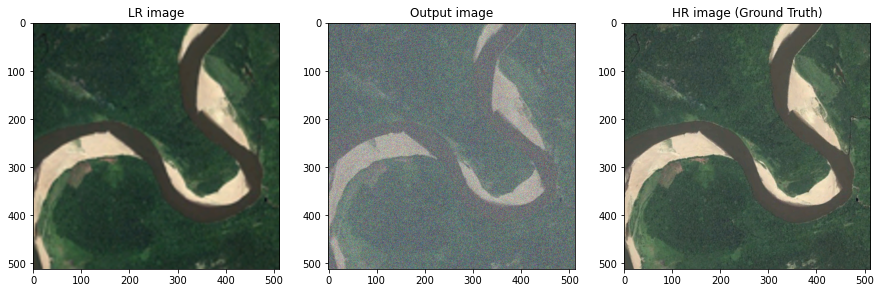

sampling loop time step: 100%|██████████| 500/500 [00:48<00:00, 10.39it/s]


<Figure size 432x288 with 0 Axes>

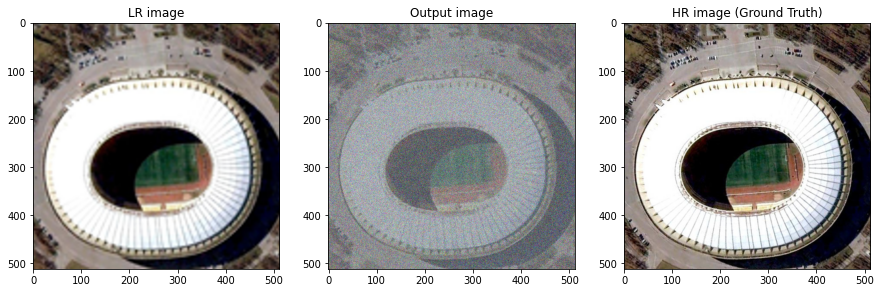

sampling loop time step: 100%|██████████| 500/500 [00:48<00:00, 10.41it/s]


<Figure size 432x288 with 0 Axes>

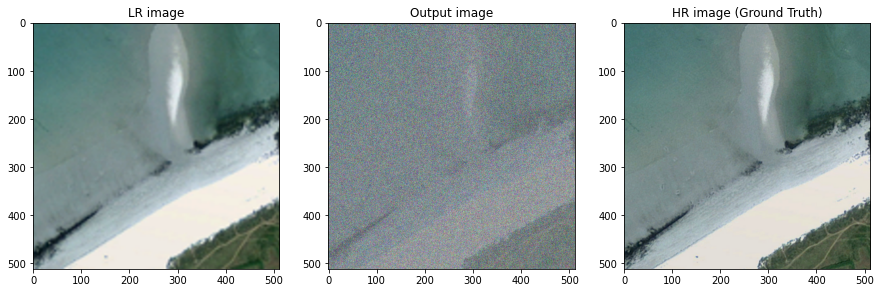

sampling loop time step: 100%|██████████| 500/500 [00:48<00:00, 10.39it/s]


<Figure size 432x288 with 0 Axes>

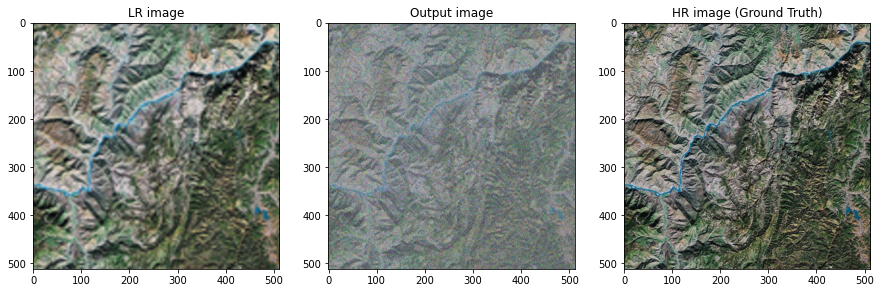

sampling loop time step: 100%|██████████| 500/500 [00:48<00:00, 10.38it/s]


<Figure size 432x288 with 0 Axes>

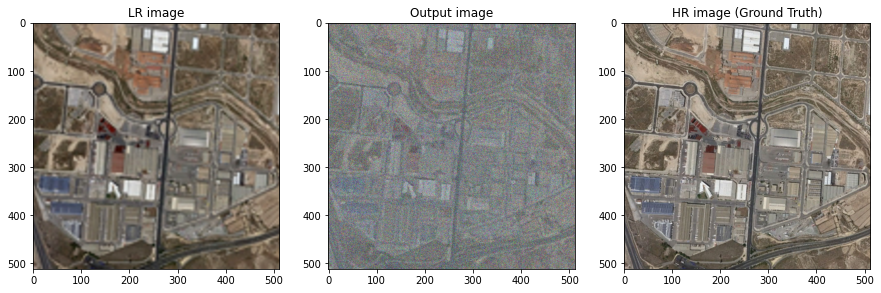

sampling loop time step: 100%|██████████| 500/500 [00:48<00:00, 10.39it/s]


<Figure size 432x288 with 0 Axes>

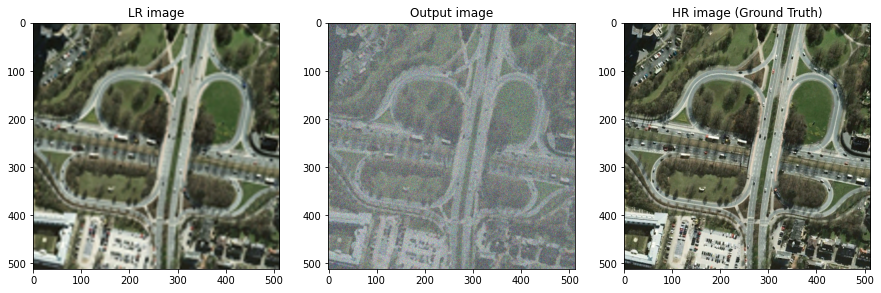

In [ ]:
load_checkpoint(torch.load("./satellite/model_weights/epoch22.pth.tar"), netG, optG)

l1_loss, mse_loss, psnr_list, ssim_list, lpips_list, output_list = test_eval(image_datasets['test'], netG)

In [ ]:
!zip -r satellite_results_diffusion_epoch22.zip satellite/results

  adding: satellite/results/ (stored 0%)
  adding: satellite/results/test_image90.pdf (deflated 1%)
  adding: satellite/results/test_image70.pdf (deflated 1%)
  adding: satellite/results/test_image30.pdf (deflated 1%)
  adding: satellite/results/test_image20.pdf (deflated 1%)
  adding: satellite/results/test_image_denseresidential_364.pdf (deflated 1%)
  adding: satellite/results/test_image10.pdf (deflated 1%)
  adding: satellite/results/test_image60.pdf (deflated 1%)
  adding: satellite/results/test_image50.pdf (deflated 1%)
  adding: satellite/results/test_image0.pdf (deflated 1%)
  adding: satellite/results/test_image80.pdf (deflated 1%)
  adding: satellite/results/test_image40.pdf (deflated 1%)
  adding: satellite/results/train_image_denseresidential_364.pdf (deflated 1%)


In [ ]:
print(np.mean(l1_loss))
print(np.mean(mse_loss))
print(np.mean(psnr_list))
print(np.mean(lpips_list))
print(np.mean(ssim_list))

0.0352098947390914
0.003509794478304684
154.38852
-0.00045274844
0.6478391


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# Evaluate model performance on test dataset
def base_eval(test_data):
    l1_loss = []
    mse_loss = []
    psnr_list = []
    ssim_list = []
    output_list = []
    lpips_list = []
    criterion1 = nn.L1Loss()
    criterion2 = nn.MSELoss()

    for i in range(0,100,10):
        images = test_data[i]
        input = images['4x'].to(device)
        target = images['1x'].to(device)
   
        # Compute L1 loss
        loss = criterion1(input,target)
        l1_loss.append(loss.item())

        # Compute MSE loss
        loss2 = criterion2(input,target)
        mse_loss.append(loss2.item())

        # Compute PSNR 
        psnr_value = psnr(input, target)
        psnr_value = psnr_value.clone().cpu().detach().numpy()
        psnr_list.append(psnr_value)
        
        # Compute SSIM
        ssim_value = ssim(input.unsqueeze(0), target.unsqueeze(0))
        ssim_value = ssim_value.clone().cpu().detach().numpy()
        ssim_list.append(ssim_value)

        # Compute LPIPS
        d = loss_fn.forward(input,target).clone().cpu().detach().numpy()
        lpips_list.append(d)

    return l1_loss, mse_loss, psnr_list, ssim_list, lpips_list, output_list

In [ ]:
load_checkpoint(torch.load("./celebA/model_weights/32_128/epoch25.pth.tar"), netG, optG)
l1_loss, mse_loss, psnr_list, ssim_list, lpips_list, output_list = base_eval(image_datasets['test'])

=> Loading checkpoint


In [ ]:
print(np.mean(l1_loss))
print(np.mean(mse_loss))
print(np.mean(psnr_list))
print(np.mean(lpips_list))
print(np.mean(ssim_list))

0.0352098947390914
0.003509794478304684
154.38852
-0.00045274844
0.6478391


In [ ]:
!zip -r satellite.zip ./satellite -x ./satellite/data/\*

updating: satellite/ (stored 0%)
updating: satellite/satellite_results_diffusion_epoch22.zip (stored 0%)
updating: satellite/results/ (stored 0%)
updating: satellite/results/test_image90.pdf (deflated 1%)
updating: satellite/results/test_image70.pdf (deflated 1%)
updating: satellite/results/test_image30.pdf (deflated 1%)
updating: satellite/results/test_image20.pdf (deflated 1%)
updating: satellite/results/test_image_denseresidential_364.pdf (deflated 1%)
updating: satellite/results/test_image10.pdf (deflated 1%)
updating: satellite/results/test_image60.pdf (deflated 1%)
updating: satellite/results/test_image50.pdf (deflated 1%)
updating: satellite/results/test_image0.pdf (deflated 1%)
updating: satellite/results/test_image80.pdf (deflated 1%)
updating: satellite/results/test_image40.pdf (deflated 1%)
updating: satellite/results/train_image_denseresidential_364.pdf (deflated 1%)
updating: satellite/.ipynb_checkpoints/ (stored 0%)
updating: satellite/model_weights/ (stored 0%)
updating: